# Data processing and exploration

A plot or two of the images/class balances should suffice

In [1]:
import pickle

train = 'C:/Users/Barotp/Downloads/traffic-signs-data/train.p'
test = 'C:/Users/Barotp/Downloads/traffic-signs-data/test.p'

with open(train, mode='rb') as f:
    train = pickle.load(f)
with open(test, mode='rb') as f:
    test = pickle.load(f)

# Get some details about dataset
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (39209, 32, 32, 3)
y_train shape: (39209,)
X_test shape: (12630, 32, 32, 3)
y_test shape: (12630,)


In [2]:
import numpy as np

n_train = len(X_train)

n_test = len(X_test)

image_shape = X_train[0].shape

n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


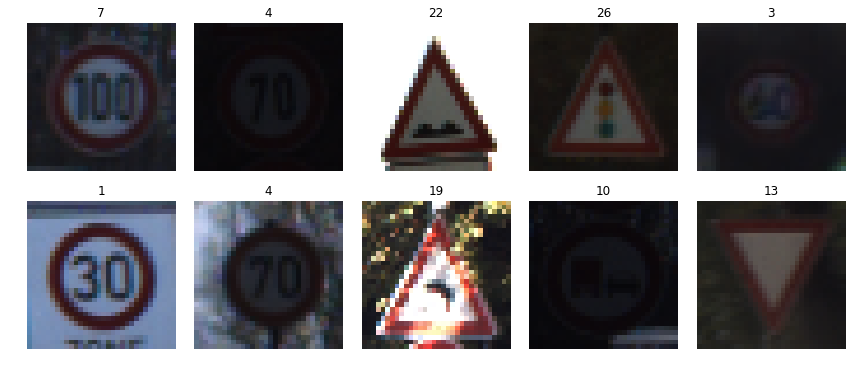

In [3]:
import matplotlib.pyplot as plt
import random
%matplotlib inline

fig, axs = plt.subplots(2,5, figsize = (15,6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = random.randint(0, len(X_train))
    image = X_train[index]
    axs[i].axis('off')
    axs[i].imshow(image)
    axs[i].set_title(y_train[index])

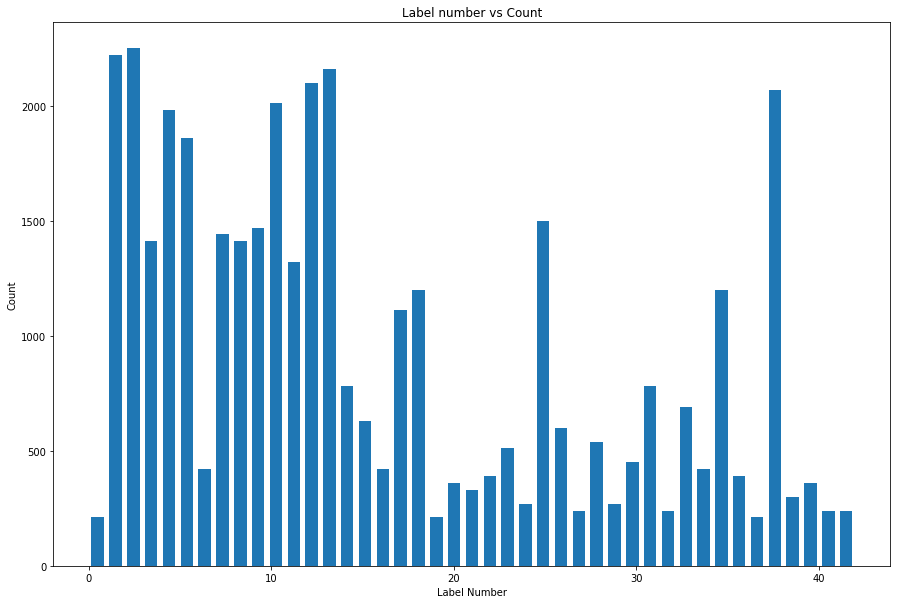

In [4]:
hist, bins = np.histogram(y_train, bins = n_classes)
width = 0.7* (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.figure(figsize=(15,10))

plt.bar(center, hist, align='center', width=width)
plt.xlabel("Label Number")
plt.ylabel("Count")
plt.title("Label number vs Count")
plt.show()

# Model development

A version of the LeNet-5 CNN architecture will be written, edited for this specific problem and tweaked as per my personal preferences

In [10]:
X_train_rgb = X_train

In [18]:
X_train_gry = np.sum((X_train.astype(np.float32) -128)/3, axis=3, keepdims=True)

X_test_rgb = X_test
X_test_gry = np.sum(X_test/3, axis=3, keepdims=True)

print('RGB shape:', X_train_rgb.shape)
print('Grayscale shape:', X_train_gry.shape)

MemoryError: 

In [25]:
print(np.mean((X_train)))
print(np.mean(X_test))

82.66505234601485
82.14846036120183


In [26]:
X_train_normalized = (X_train - 128)/128 
X_test_normalized = (X_test - 128)/128

print(np.mean(X_train_normalized))
print(np.mean(X_test_normalized))

MemoryError: 